In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


# **1.Introduction**

**Goal of the Project**

Want to predict the insurance premium amount for each customer based on the features provided in the dataset.

The premium is typically calculated based on factors that:

Reflect the risk of insuring a customer (e.g., age, health score, vehicle age, etc.).Affect the policy cost (e.g., credit score, insurance duration, policy type).


# **2.Data Understanding**

# **Import Necessary Libraries:**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.linear_model import Lasso,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error,make_scorer
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


In [3]:
train=pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
test=pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")



In [4]:
train

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,...,NaN,5.0,372.0,3.0,2023-05-03 15:21:39.257696,Poor,No,Daily,Apartment,1303.0
1199996,1199996,54.0,Male,35786.0,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,...,NaN,10.0,597.0,4.0,2022-09-10 15:21:39.134960,Poor,No,Weekly,Apartment,821.0
1199997,1199997,19.0,Male,51884.0,Divorced,0.0,Master's,NaN,14.724469,Suburban,...,0.0,19.0,NaN,6.0,2021-05-25 15:21:39.106582,Good,No,Monthly,Condo,371.0
1199998,1199998,55.0,Male,NaN,Single,1.0,PhD,NaN,18.547381,Suburban,...,1.0,7.0,407.0,4.0,2021-09-19 15:21:39.190215,Poor,No,Daily,Apartment,596.0


In [5]:
test

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,1999995,50.0,Female,38782.0,Married,1.0,Bachelor's,NaN,14.498639,Rural,Premium,NaN,8.0,309.0,2.0,2021-07-09 15:21:39.184157,Average,Yes,Daily,Condo
799996,1999996,NaN,Female,73462.0,Single,0.0,Master's,NaN,8.145748,Rural,Basic,2.0,0.0,NaN,2.0,2023-03-28 15:21:39.250151,Good,No,Daily,Apartment
799997,1999997,26.0,Female,35178.0,Single,0.0,Master's,Employed,6.636583,Urban,Comprehensive,NaN,10.0,NaN,6.0,2019-09-30 15:21:39.132191,Poor,No,Monthly,Apartment
799998,1999998,34.0,Female,45661.0,Single,3.0,Master's,NaN,15.937248,Urban,Premium,2.0,17.0,467.0,7.0,2022-05-09 15:21:39.253660,Average,No,Weekly,Condo


In [6]:
print('train data: ', train.shape)
print('test data: ', test.shape)

train data:  (1200000, 21)
test data:  (800000, 20)


In [7]:
print("train data:", train.columns)
print("test data:", test.columns)

train data: Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')
test data: Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type'],
      dtype='object')


In [8]:
train.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
id,1200000.0,599999.50,346410.31,0.00,299999.75,599999.50,899999.25,1199999.00
Age,1181295.0,41.15,13.54,18.00,30.00,41.00,53.00,64.00
Annual Income,1155051.0,32745.22,32179.51,1.00,8001.00,23911.00,44634.00,149997.00
Number of Dependents,1090328.0,2.01,1.42,0.00,1.00,2.00,3.00,4.00
Health Score,1125924.0,25.61,12.20,2.01,15.92,24.58,34.53,58.98
Previous Claims,835971.0,1.00,0.98,0.00,0.00,1.00,2.00,9.00
Vehicle Age,1199994.0,9.57,5.78,0.00,5.00,10.00,15.00,19.00
Credit Score,1062118.0,592.92,149.98,300.00,468.00,595.00,721.00,849.00
Insurance Duration,1199999.0,5.02,2.59,1.00,3.00,5.00,7.00,9.00
Premium Amount,1200000.0,1102.54,865.00,20.00,514.00,872.00,1509.00,4999.00


# **Explore Columns and Data types:**

# Column Description:

id: Unique identifier for each customer.

Age: Age of the customer in years.

Gender: Gender of the customer (e.g., Male, Female).

Annual Income: Annual income of the customer in currency units.

Marital Status: Marital status of the customer (e.g., Single, Married).

Number of Dependents: Number of dependents the customer has.(Number of Dependents refers to the number of individuals financially dependent on the customer. These could include children, elderly parents, or any other family members who rely on the customer for financial support.)

Education Level: Customer's highest level of education.

Occupation: Customer's occupation or job role.

Health Score: A numerical representation of the customer's health condition.

Location: Geographic location of the customer.

Policy Type: Type of insurance policy the customer holds.

Previous Claims: Number of previous insurance claims made by the customer.

Vehicle Age: Age of the vehicle in years.

Credit Score: Customer's creditworthiness score.

Insurance Duration: Duration of the current insurance policy.

Policy Start Date: Start date of the insurance policy.

Customer Feedback: Feedback or ratings provided by the customer.

Smoking Status: Whether the customer is a smoker or not.

Exercise Frequency: Frequency of physical exercise by the customer.

Property Type: Type of property the customer owns (e.g., Apartment, House).

Premium Amount: The amount paid as the insurance premium.


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

**Irrelevant Columns:**

**1.Policy Start Date:** The date itself doesn’t usually determine how much premium should be charged. Instead, what might matter is the duration of the policy .

**2.Customer Feedback:** The feedback is subjective and reflects the customer’s perception, not their risk profile or the cost factors that influence premium calculations.

**3.Location:** The geographic location of the customer.If location is strongly correlated with other variables like accident rates, medical costs, or property values, it might influence the premium

In [10]:
train.drop(columns=['id','Policy Start Date','Location','Customer Feedback'],inplace=True)

test.drop(columns=['Policy Start Date','Location','Customer Feedback'],inplace=True)

# **Missing Values and Duplicate Values:**

In [11]:
train.isnull().sum()

Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [12]:
test.isnull().sum()

id                           0
Age                      12489
Gender                       0
Annual Income            29860
Marital Status           12336
Number of Dependents     73130
Education Level              0
Occupation              239125
Health Score             49449
Policy Type                  0
Previous Claims         242802
Vehicle Age                  3
Credit Score             91451
Insurance Duration           2
Smoking Status               0
Exercise Frequency           0
Property Type                0
dtype: int64

In [13]:
train.duplicated().sum()

3

In [14]:
test.duplicated().sum()

0

# **Numerical and Categorical Columns**

In [15]:
tar_col ='Premium Amount';
num_col = train.select_dtypes(include = ['number']).columns
cat_col = train.select_dtypes(include = ['object']).columns
print("Target Column :" ,tar_col)
print( "\nNumerical Columns :" , num_col.tolist())
print( "\nCategorical Columns :" , cat_col.tolist())

Target Column : Premium Amount

Numerical Columns : ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Premium Amount']

Categorical Columns : ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Policy Type', 'Smoking Status', 'Exercise Frequency', 'Property Type']


In [16]:
num_data=train.select_dtypes(include=['number'])
cat_data=train.select_dtypes(include=['object'])

In [17]:
print('Numerical Data Distribution!')
num_data.describe().round(2).T

Numerical Data Distribution!


,count,mean,std,min,25%,50%,75%,max
Age,1181295.0,41.15,13.54,18.00,30.00,41.00,53.00,64.00
Annual Income,1155051.0,32745.22,32179.51,1.00,8001.00,23911.00,44634.00,149997.00
Number of Dependents,1090328.0,2.01,1.42,0.00,1.00,2.00,3.00,4.00
Health Score,1125924.0,25.61,12.20,2.01,15.92,24.58,34.53,58.98
Previous Claims,835971.0,1.00,0.98,0.00,0.00,1.00,2.00,9.00
Vehicle Age,1199994.0,9.57,5.78,0.00,5.00,10.00,15.00,19.00
Credit Score,1062118.0,592.92,149.98,300.00,468.00,595.00,721.00,849.00
Insurance Duration,1199999.0,5.02,2.59,1.00,3.00,5.00,7.00,9.00
Premium Amount,1200000.0,1102.54,865.00,20.00,514.00,872.00,1509.00,4999.00


In [18]:
print("Categorical Data Dsicription!")
cat_data.describe().T

Categorical Data Dsicription!


,count,unique,top,freq
Gender,1200000,2,Male,602571
Marital Status,1181471,3,Single,395391
Education Level,1200000,4,Master's,303818
Occupation,841925,3,Employed,282750
Policy Type,1200000,3,Premium,401846
Smoking Status,1200000,2,Yes,601873
Exercise Frequency,1200000,4,Weekly,306179
Property Type,1200000,3,House,400349


In [19]:
for c in cat_data:
    col_count=train[c].nunique()
    print(f'{c} has {col_count} unqiue_values: ')
    print("--"*20)

Gender has 2 unqiue_values: 
----------------------------------------
Marital Status has 3 unqiue_values: 
----------------------------------------
Education Level has 4 unqiue_values: 
----------------------------------------
Occupation has 3 unqiue_values: 
----------------------------------------
Policy Type has 3 unqiue_values: 
----------------------------------------
Smoking Status has 2 unqiue_values: 
----------------------------------------
Exercise Frequency has 4 unqiue_values: 
----------------------------------------
Property Type has 3 unqiue_values: 
----------------------------------------


In [20]:
for i in cat_col:
    cat_value=train[i].value_counts()
    print(f"Value Count for {i}")
    print(cat_value)
    print("*"*40)

Value Count for Gender
Gender
Male      602571
Female    597429
Name: count, dtype: int64
****************************************
Value Count for Marital Status
Marital Status
Single      395391
Married     394316
Divorced    391764
Name: count, dtype: int64
****************************************
Value Count for Education Level
Education Level
Master's       303818
PhD            303507
Bachelor's     303234
High School    289441
Name: count, dtype: int64
****************************************
Value Count for Occupation
Occupation
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64
****************************************
Value Count for Policy Type
Policy Type
Premium          401846
Comprehensive    399600
Basic            398554
Name: count, dtype: int64
****************************************
Value Count for Smoking Status
Smoking Status
Yes    601873
No     598127
Name: count, dtype: int64
****************************************

# **3.Data Preprocessing**:

# **Data Coversion**

In [21]:
conversion_column=['Age','Number of Dependents','Previous Claims','Vehicle Age','Insurance Duration']
for i in conversion_column:
    train[i]=train[i].fillna(0).astype(int)
    

**Check the Percentage of Rows Affected:**


In [22]:
# Percentage of rows with nulls in 'Occupation' and 'Previous Claims'
affected_rows = train[train['Occupation'].isnull() | train['Previous Claims'].isnull()]
print(len(affected_rows) / len(train) * 100)


29.839583333333337


**If a large percentage of rows  >20% are affected, dropping these rows might harm the dataset's quality.**

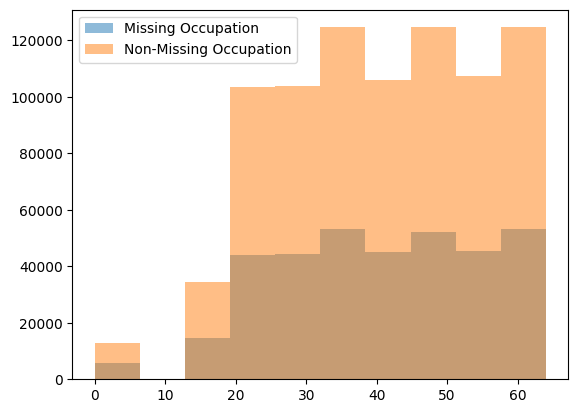

In [23]:
# Example: Compare 'Age' distribution
import matplotlib.pyplot as plt
plt.hist(train[train['Occupation'].isnull()]['Age'], alpha=0.5, label='Missing Occupation')
plt.hist(train[train['Occupation'].notnull()]['Age'], alpha=0.5, label='Non-Missing Occupation')
plt.legend()
plt.show()


In [24]:
X=train.drop('Premium Amount',axis=1)
y=train['Premium Amount']

In [25]:
num_col=num_col.drop(['Premium Amount'])

# **Feature Scaling & Encoding**:


In [26]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Scale features
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical variables
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer,num_col),
        ('cat', categorical_transformer, cat_col)
    ]
)

X_processed = preprocessor.fit_transform(X)
test_transformed = preprocessor.transform(test.drop(columns=['id']))


# **4.Train_Test_Split**

In [27]:
X_train,X_test,y_train,y_test=train_test_split(X_processed,y,test_size=0.2,random_state=42)

# **5.Model Training By Multiple Model**

In [28]:
models={'linear Regression': LinearRegression(),
       'Decisoin Tree ': DecisionTreeRegressor(),
       'XGBoost':XGBRegressor()
       }

#train and evaluate each model
for model_name,model in models.items():
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    rmsle= np.sqrt(mean_squared_log_error(y_test,y_pred))
    
    print(f'{model_name} Accuracy : {rmsle:.2f}')
    

linear Regression Accuracy : 1.17
Decisoin Tree  Accuracy : 1.52
XGBoost Accuracy : 1.15


**XGBoost Regressor outperforms Linear Regression with a lower RMSLE (1.15 vs. 1.17), indicating better predictive accuracy. However, both models fall into the "Poor (> 1.0)" range, suggesting room for improvement through hyperparameter tuning .**

# **6.Hyperparameter Tuning:**

# Select XGBRegressor

In [29]:
# Define the model
xgb_model = XGBRegressor(eval_metric='rmsle', tree_method='hist',random_State=42)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Define GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid, 
    error_score='raise',# Using MSE for the search
    
)



In [30]:
# Fit the grid search
#grid_search.fit(X_train, y_train)

# Access the best parameters
#best_parameters = grid_search.best_params_
#print("Best Parameters: ", best_parameters)

In [31]:
best_parameter =  {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}


In [32]:
xgb_mb= XGBRegressor(**best_parameter) # Unpack the best_parameter dictionary
xgb_mb.fit(X_train ,y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# **7.Model Evaluation**

In [33]:
y_test = np.nan_to_num(y_test)


RMSLE : 1.1513134768899513 


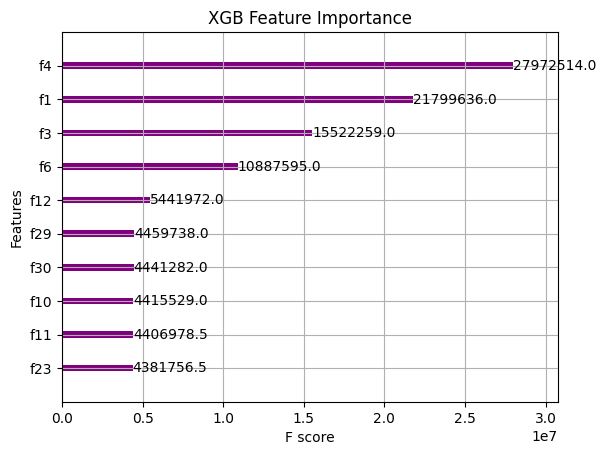

In [34]:
y_pred = xgb_mb.predict(X_test)
rmsle= np.sqrt(mean_squared_log_error(y_test,y_pred))
print(f"RMSLE : {rmsle} " )


plot_importance(xgb_mb, importance_type='gain', title='XGB Feature Importance', max_num_features=10, color='purple')
sns.set_palette('viridis')


**Column Mapping:**
f0: Age

f1: Gender

f2: Annual Income

f3: Marital Status

f4: Number of Dependents

f5: Education Level

f6: Occupation

f7: Health Score

f8: Policy Type

f9: Previous Claims

f10: Vehicle Age

f11: Credit Score

f12: Insurance Duration

f13: Smoking Status

f14: Exercise Frequency

f15: Property Type

The feature importance analysis reveals that **Number of Dependents, Gender, Marital Status, and Occupation** significantly influence the **Premium Amount**. These features likely affect the target variable as they provide critical insights into the policyholder's profile, such as financial responsibilities, demographic factors, and risk levels, which are essential for determining insurance premiums.

# **8.Submission**

In [35]:
output= pd.DataFrame(test['id'])
xgb_output = xgb_mb.predict(test_transformed)
output['Premium Amount']= xgb_output
output.to_csv("/kaggle/working/submission.csv", index = None)
output.head()

,id,Premium Amount
0,1200000,1438.783691
1,1200001,1124.194824
2,1200002,1081.160889
3,1200003,1090.936035
4,1200004,1050.079956
